In [50]:
# Importing necessary modules

In [22]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
#import torch
import pytesseract
import numpy as np
from typing import List, Tuple

In [23]:
import sys
# Add the current directory to the system path
sys.path.append('.')

In [24]:
data_path = '../Data/'

In [25]:
per_df = pd.read_csv(data_path+'performance_data.csv')

In [26]:
per_df.head()

,game_id,preview_link,ER,CTR
0,bfbf7a2b7ac635e67877b1ab87fd6629,https://s3.us-east-1.amazonaws.com/a.futureadl...,0.209269,0.058438
1,945010afbf9a55bbdffcb0895f946155,https://s3.us-east-1.amazonaws.com/a.futureadl...,0.274552,0.074731
2,e68e20f592457b875ce29757ab855dfe,https://s3.us-east-1.amazonaws.com/a.futureadl...,0.103688,0.042228
3,adunit-nestle-purina-friskies-mob,https://s3.ap-southeast-1.amazonaws.com/a.futu...,0.136963,0.005393
4,adunit-lionsgate-uwomt-user-slider-sensory-vid...,https://s3.us-west-1.amazonaws.com/a.futureadl...,0.114208,0.016443


In [27]:
per_df['preview_link'][0]

'https://s3.us-east-1.amazonaws.com/a.futureadlabs.com-us-east-1-backup/us-east-1/games/bfbf7a2b7ac635e67877b1ab87fd6629/b7a604b3b08f0862ef0e/index.html'

In [28]:
concepts_df = pd.read_json(data_path+'concepts.json')

In [29]:
concepts_df.head()

,concept,implementation,explanation,asset_suggestions
0,Escape Challenge Teaser,{'frame_1': {'description': 'The ad begins wit...,This concept aligns with LEGO CITY's brand ide...,[{'frame_1': {'Background Animation': 'A suspe...
1,Interactive Storytelling,{'frame_1': {'description': 'The ad opens with...,This concept aligns with LEGO CITY's brand ide...,[{'frame_1': {'Background Animation': 'A suspe...
2,City Tour,{'frame_1': {'description': 'The ad begins wit...,This concept aligns with LEGO CITY's brand ide...,[{'frame_1': {'Background Animation': 'A suspe...
3,Interactive Globe Journey,{'frame_1': {'description': 'The ad opens with...,This concept aligns with the brand's identity ...,[{'frame_1': {'3D Globe': 'A high-definition 3...
4,Cultural Carousel,{'frame_1': {'description': 'A carousel of cul...,This concept leverages the brand's diverse por...,[{'frame_1': {'Background Image': 'A high-reso...


In [30]:
concepts_df.shape

(115, 4)

In [31]:
concepts_df['explanation'][0]

"This concept aligns with LEGO CITY's brand identity of providing fun and entertainment. It appeals to the target demographic's interest in games and challenges, and it achieves the campaign's objectives of enhancing audience engagement, increasing product and brand awareness, and driving traffic to the brand's website. The concept is scalable and can be adapted for various platforms and audiences. It can be executed within the given budget constraints."

In [32]:
concepts_df['asset_suggestions'][0]

[{'frame_1': {'Background Animation': "A suspenseful animation of a LEGO CITY set, with buildings, vehicles, and mini-figures coming to life in a dynamic, 3D environment. The animation is designed to captivate the viewer's attention and set the stage for the upcoming challenge.",
   'Tagline': "'YOUR CITY, NO LIMITS' appears in bold, vibrant letters, reinforcing the campaign's theme of boundless creativity and adventure.",
   'Countdown Timer': "A digital countdown timer, styled to resemble LEGO bricks, adds an element of suspense and anticipation, building up to the reveal of the 'ULTIMATE ESCAPE CHALLENGE'."},
  'frame_2': {'Video Clips': "A series of quick, exciting clips showcasing various challenges in the 'ULTIMATE ESCAPE CHALLENGE'. Each clip features different LEGO CITY sets and mini-figures, highlighting the diversity and expansiveness of the LEGO CITY universe.",
   'Swipe Indicator': 'A subtle, animated swipe indicator encourages viewers to interact with the ad and explore t

In [33]:
len(concepts_df['asset_suggestions'][0])

5

In [45]:
len(concepts_df['asset_suggestions'][0][0])

4

In [41]:
Frames=[]
for i in range(len(concepts_df['asset_suggestions'][0][0])-1):
    Frames.append(concepts_df['asset_suggestions'][0][0][f'frame_{i+1}'])

In [46]:
len(Frames)

3

#

In [43]:
for key, value in Frames[0].items():
    category = key
    prompt = value
    if category.contains("Background"):
        category = 'Background Image'
    print("Category:", category)
    print("prompt:", prompt)

Category: Background Animation
prompt: A suspenseful animation of a LEGO CITY set, with buildings, vehicles, and mini-figures coming to life in a dynamic, 3D environment. The animation is designed to captivate the viewer's attention and set the stage for the upcoming challenge.
Category: Tagline
prompt: 'YOUR CITY, NO LIMITS' appears in bold, vibrant letters, reinforcing the campaign's theme of boundless creativity and adventure.
Category: Countdown Timer
prompt: A digital countdown timer, styled to resemble LEGO bricks, adds an element of suspense and anticipation, building up to the reveal of the 'ULTIMATE ESCAPE CHALLENGE'.


In [39]:
categories_df = pd.read_csv(data_path+'categories.txt')

In [40]:
categories_df

,Categories
0,1. Background Image
1,2. Logo
2,3. Call-To-Action (CTA) Button
3,4. Icon
4,5. Product Image
5,6. Text Elements
6,7. Infographic
7,8. Banner
8,9. Illustration
9,10. Photograph


In [26]:
def locate_image_on_image(locate_image: str, on_image: str, prefix: str = '', visualize: bool = False, color: Tuple[int, int, int] = (0, 0, 255)):
    try:

        image = cv2.imread(on_image)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        template = cv2.imread(locate_image, 0)

        result = cv2.matchTemplate(gray, template, cv2.TM_CCOEFF)
        _, _, _, max_loc = cv2.minMaxLoc(result)

        height, width = template.shape[:2]

        top_left = max_loc
        bottom_right = (top_left[0] + width, top_left[1] + height)

        if visualize:
            cv2.rectangle(image, top_left, bottom_right, color, 1)
            plt.figure(figsize=(10, 10))
            plt.axis('off')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image)

        return {f'{prefix}top_left_pos': top_left, f'{prefix}bottom_right_pos': bottom_right}

    except cv2.error as err:
        print(err)

{'eng_top_left_pos': (178, 750), 'eng_bottom_right_pos': (422, 849)}

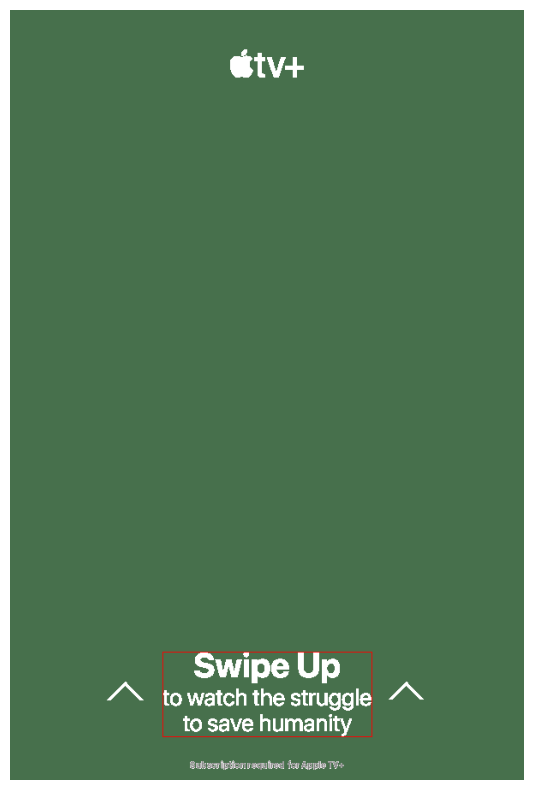

In [27]:
locate_image_on_image('../Data/Assets/4c3bb41d4f40f39842b7b8d3f536366a/engagement_instruction.png', '../Data/Assets/4c3bb41d4f40f39842b7b8d3f536366a/_preview.png', prefix='eng_', visualize=True)


{'eng_top_left_pos': (50, 114), 'eng_bottom_right_pos': (430, 177)}

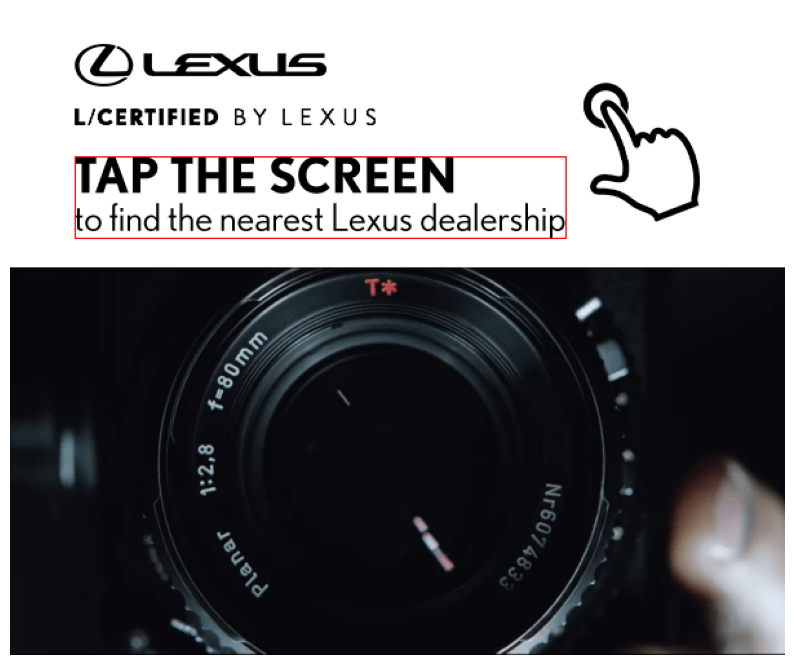

In [28]:
locate_image_on_image('../Data/Assets/5a48ffcbf611f167ecbb884e807f31f6/engagement_instruction.png', '../Data/Assets/5a48ffcbf611f167ecbb884e807f31f6/_preview.png', prefix='eng_', visualize=True)

In [29]:
!pip install extcolors
!pip install colormap

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Using cached pexpect-4.9.0-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached platformdirs-4.2.0-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 428.4 kB/s eta 0:00:00 kB/s eta 0:00:011
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 714.8/714.8 kB 447.3 kB/s eta 0:00:00m eta 0:00:010:01:01
Using cached pexpect-4.9.0-py2.py3-none-any.whl (63 kB)
Using cached platformdirs-4.2.0-py3-none-any.whl (17 kB)
  Created wheel for colormap: filename=colormap-1.0.6-py3-none-any.whl size=15830 sha256=6ab1f558d9ce6dec39d6010e0cbfd798694304ea4dc430ae1ba3aadf230f85d1
  Stored in directory: /home/eyaya/.cache/pip/wheels/ea/c2/2c/8799f753a6c0acef2a86a40c7c091fa70d0f49785f1f28fba1
Successfully built colormap
  Attempting uninstall: platformdirs
    Found existing inst

In [30]:
import extcolors
import pandas as pd
from colormap import rgb2hex
from matplotlib import pyplot as plt
from PIL import Image

In [31]:
def identify_color_composition(image,
                               tolerance: int = 12,
                               limit: int = 2,
                               visualize: bool = False) -> None:
    """Function that identifies the color composition of a
    given image path."""

    extracted_colors = extcolors.extract_from_path(
        image, tolerance=tolerance, limit=limit)

    identified_colors = color_to_df(extracted_colors)

    if not visualize:
        return identified_colors

    list_color = list(identified_colors['c_code'])
    list_percent = [int(i) for i in list(identified_colors['occurrence'])]

    text_c = [c + ' ' + str(round(p*100/sum(list_percent), 1)) + '%' for c, p in zip(list_color,
                                                                                     list_percent)]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100), dpi=10)
    wedges, _ = ax[0].pie(list_percent,
                          labels=text_c,
                          labeldistance=1.05,
                          colors=list_color,
                          textprops={'fontsize': 60, 'color': 'black'}
                          )

    plt.setp(wedges, width=0.3)

    # create space in the center
    plt.setp(wedges, width=0.36)

    ax[0].set_aspect("equal")
    fig.set_facecolor('grey')

    ax[1].imshow(Image.open(image))

    plt.show()

    return identified_colors


def color_to_df(extracted_colors: tuple):
    """Converts RGB Color values from extcolors output to HEX Values."""

    colors_pre_list = str(extracted_colors).replace(
        '([(', '').replace(')],', '), (').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')', '')
                  for i in colors_pre_list]

    # convert RGB to HEX code
    df_rgb_values = [(int(i.split(", ")[0].replace("(", "")),
                      int(i.split(", ")[1]),
                      int(i.split(", ")[2].replace(")", ""))) for i in df_rgb]

    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(", "")),
                           int(i.split(", ")[1]),
                           int(i.split(", ")[2].replace(")", ""))) for i in df_rgb]

    colors_df = pd.DataFrame(zip(df_color_up, df_rgb_values, df_percent),
                             columns=['c_code', 'rgb', 'occurrence'])

    return colors_df


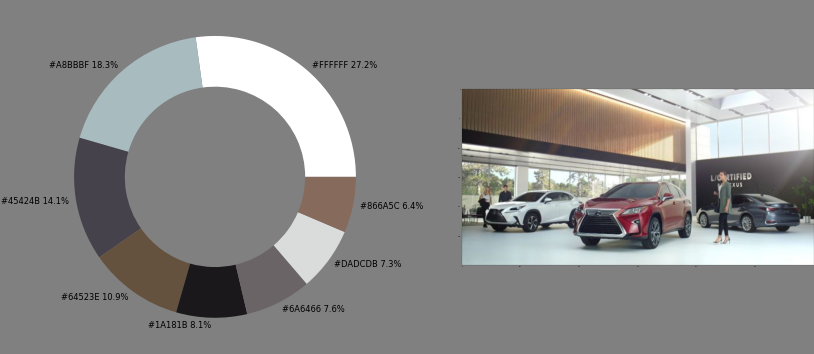

,c_code,rgb,occurrence
0,#FFFFFF,"(255, 255, 255)",40541
1,#A8BBBF,"(168, 187, 191)",27323
2,#45424B,"(69, 66, 75)",21087
3,#64523E,"(100, 82, 62)",16217
4,#1A181B,"(26, 24, 27)",12113
5,#6A6466,"(106, 100, 102)",11333
6,#DADCDB,"(218, 220, 219)",10916
7,#866A5C,"(134, 106, 92)",9537


In [32]:
identify_color_composition('../Data/Assets/5a48ffcbf611f167ecbb884e807f31f6/landing_2.jpg',tolerance=12,limit=8, visualize=True)

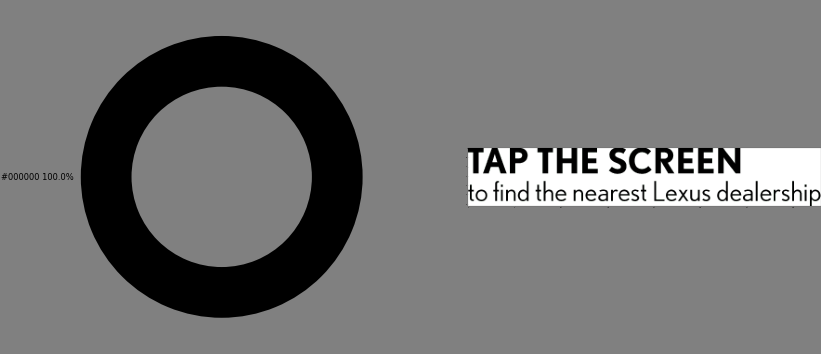

,c_code,rgb,occurrence
0,#000000,"(0, 0, 0)",7175


In [33]:
identify_color_composition('../Data/Assets/5a48ffcbf611f167ecbb884e807f31f6/engagement_instruction.png', visualize=True)

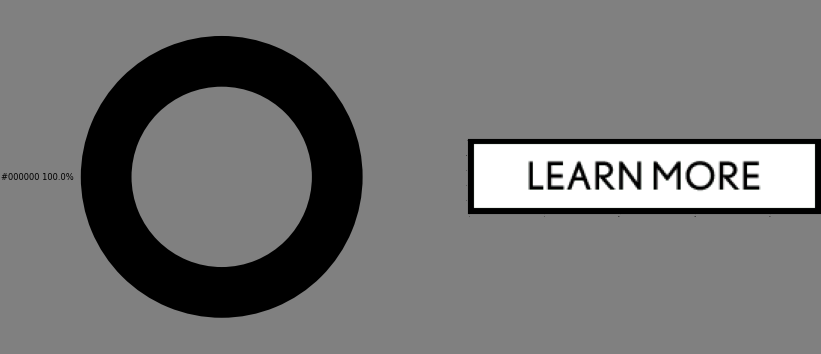

,c_code,rgb,occurrence
0,#000000,"(0, 0, 0)",3577


In [34]:
identify_color_composition('../Data/Assets/5a48ffcbf611f167ecbb884e807f31f6/cta.png', limit=3 ,visualize=True)

!sudo apt install tesseract-ocr
!pip install pytesseract

In [43]:

def convert_hex_to_rgb(hex_color: str, normalize: bool = True) -> List[str]:
    """Converts a HEX color to a RGB color

    Args:
        hex_color (str): HEX color code to convert
        normalize (bool, optional): Choice to normalize calculated rgb values . Defaults to True.

    Returns:
        List[str]: List of RGB values in order, normalized or not.
    """
    colors = hex_color[1:]

    # Convert HEX color values to RGB Values
    colors = [int(colors[0:2], base=16),  # RED
              int(colors[2:4], base=16),  # GREEN
              int(colors[4:6], base=16)]  # BLUE

    # Normalize RGB values
    if normalize:
        colors = [color / 255 for color in colors]

    return colors

def get_luminance(hex_color: str) -> float:
    """Calculates the luminance of a given HEX color

    Args:
        hex_color (str): HEX color code to calculate luminance for

    Returns:
        float: luminance value of color
    """
    colors = convert_hex_to_rgb(hex_color)

    luminance = colors[0] * 0.2126 + colors[1] * 0.7152 + colors[2] * 0.0722

    return luminance

def fix_image_background(image_path: str):
    identified_colors = identify_color_composition(image_path)
    text_color = identified_colors['c_code'].to_list()[0]
    text_color_rgb = identified_colors['rgb'].to_list()[0]
    luminance = get_luminance(hex_color=text_color)

    if luminance < 140:
        background_color = (255, 255, 255)
    else:
        background_color = (0, 0, 0)

    # Load image
    image = cv2.imread(image_path)

    # Make all perfectly green pixels white
    image[np.all(image != text_color_rgb, axis=-1)] = background_color

    return image

def extract_text(image_path, tesseract_cmd: str = '', fix_background: bool = False):
    # pytesseract.pytesseract.tesseract_cmd = tesseract_cmd
    try:
        if fix_background:
            text = pytesseract.image_to_string(
                fix_image_background(image_path))
        else:
            text = pytesseract.image_to_string(image_path)

        return text

    except pytesseract.TesseractNotFoundError:
        raise Exception(
            f'Failure: Tesseract is not installed or not available in the defined path {tesseract_cmd}')

In [44]:
extract_text('../Data/Assets/5a48ffcbf611f167ecbb884e807f31f6/_preview.png')

'Ovexus\nL/CERTIFIED BY LEXUS\n\nTAP THE SCREEN\n\nto find the nearest Lexus dealership\n\n \n\x0c'

In [45]:
extract_text('../Data/Assets/5a48ffcbf611f167ecbb884e807f31f6/engagement_instruction.png', fix_background=True)

'TAP THE SCREEN\n\nto find the nearest Lexus dealership\n\x0c'

In [46]:
extract_text('../Data/Assets/5a48ffcbf611f167ecbb884e807f31f6/cta.png', fix_background=True)

'LEARN MORE\n\x0c'

In [88]:
# Imports
from typing import Tuple
from time import sleep
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from os import path
from subprocess import Popen, call
import pyautogui
import ffmpeg # library used for audio & videw processing and gerneration

In [89]:
class CreativeFrameExtractor:
    '''
    Class responsible for Extracting Creative Start and End Frames.
    It requires a chrome webdriver compatible with selenium to be
    installed/included in the run environment path.
    '''

    def __init__(self, preview_url: str,
                 engagement_type: str,
                 save_location: str = '',
                 browser_edges: Tuple[float, float] = (70, 1039)) -> None: # crop the image

        self.preview_url = preview_url
        self.engagement_type = engagement_type
        self.browser_edges = browser_edges
        self.file_name = '-'.join(preview_url.split('/')[-3:-1]) # extracting the file name from url
        self.save_location = save_location
        self.video_name = path.join(self.save_location, self.file_name) # video name
        self.cmd = f"ffmpeg -f gdigrab -draw_mouse 0 -framerate 60 -i desktop -vcodec libx264rgb {self.video_name}.mkv -y"

        # Configurations # of the selenium

        # Browser Configuration
        # Browser Options
        self.opt = Options()
        self.opt.add_argument("--hide-scrollbars")
        self.opt.add_experimental_option(
            "excludeSwitches", ["enable-automation"])
        # Browser Logs # If you want to extract browser logs
        self.capabilities = DesiredCapabilities.CHROME
        self.capabilities["goog:loggingPrefs"] = {"browser": "ALL"}

    def is_status_complete(self, passed_driver) -> bool:
        '''
        Function to check status of the AD-Unit and its completion. #different phases of AD
        # we use this to track when to get the end/start frame, start/end of recording
        '''
        # Retrieve logs from browser
        logs = passed_driver.get_log("browser")

        for log in logs:
            # Select logs coming from AD-Unit
            if log["source"] == "console-api":
                # Extract message from log
                message = log["message"]

                if '"GAME CREATED"' in message or '"DROPPED"' in message:
                    # Start Recording Game
                    print("Starting Recording AD-UNIT...")
                    print(log)
                    return False

                if '"START"' in message:
                    # Engaged
                    print("AD-UNIT Engaged...")
                    print(log)
                    return False

                if '"GAME COMPLETE"' in message:
                    # Stop Recording Game
                    print("Stopped Recording AD-UNIT...")
                    print(log)
                    return True

        return False

    @staticmethod
    def terminate(process: Popen[bytes]) -> None:
        '''
        Function to stop/terminate a process.
        '''
        # Video Recording Process Terminator
        if process.poll() is None:
            call("taskkill /F /T /PID " + str(process.pid))

    @staticmethod
    def crop_video(filename: str, x_pos: float = 0, y_pos: float = 70, width: float = 650, height: float = 970) -> None:
        '''
        Function to crop a video with given location and size specific parameters. # we need this because the record function records entire screen
        '''
        print(filename)
        input_video = ffmpeg.input(f"{filename}.mkv")
        cropped_video = ffmpeg.crop(input_video, x_pos, y_pos, width, height)
        output_video = ffmpeg.output(cropped_video, f"{filename}_cropped.mkv")
        ffmpeg.run(output_video)

    def _imitate_engagement(self, ad_size: Tuple[float, float]) -> None:
        '''
        Function to imitate a given engagement type. # are these comprehensive?
        '''
        center = (ad_size[0]/2, self.browser_edges[0] + (ad_size[1]/2))

        if self.engagement_type == "tap":
            pyautogui.moveTo(center[0], center[1], duration=1)
            pyautogui.leftClick()

        elif self.engagement_type == "swipe right":
            pyautogui.moveTo(center[0], center[1], duration=1)
            pyautogui.dragRel(center[0], 0, duration=1)

        elif self.engagement_type == "swipe left":
            pyautogui.moveTo(center[0], center[1], duration=1)
            pyautogui.dragRel(-center[0], 0, duration=1)

        elif self.engagement_type == "tap and hold":
            pyautogui.moveTo(center[0], center[1], duration=1)
            pyautogui.click()

        elif self.engagement_type == "scrub":
            pyautogui.moveTo(center[0] - (1/2 * center[0]),
                             center[1] - (2/3 * center[1]), duration=0.2)
            pyautogui.dragRel(center[0], 0, duration=0.2)
            pyautogui.dragRel(-center[0], (1/3 * center[1]), duration=0.2)
            pyautogui.dragRel(center[0], 0, duration=0.2)
            pyautogui.dragRel(-center[0], (1/3 * center[1]), duration=0.2)
            pyautogui.dragRel(center[0], 0, duration=0.2)

    def generate_preview_video(self) -> None:
        '''
        Function to generate preview video and also a cropped version of the video.
        '''
        # Initialize Selenium WebDriver
        driver = webdriver.Chrome(
            options=self.opt, desired_capabilities=self.capabilities)
        # Maximize WebDriver's Window to Maximum Size
        driver.maximize_window()

        try:
            # Load AD-Unit through Selenium
            driver.get(self.preview_url)

            # Locate AD-Unit Element from Browser
            canvas = driver.find_element(By.TAG_NAME, "canvas")

            # Start Recording Entire Screen
            video_recording = Popen(self.cmd)

            # Identify Size of AD-Unit
            ad_size = (canvas.size.get("width"), canvas.size.get("height"))

            # Engage Ad-Unit
            self._imitate_engagement(ad_size)

            # Continuously Check Status of AD-Unit using its console logs
            # until it reached a "GAME COMPLETE" Status
            WebDriverWait(driver, 100).until(self.is_status_complete)

            sleep(5)

            # Stop Video Recording
            self.terminate(video_recording)

            # Close Selenium Browser Window
            driver.close()

            # Crop Generated Preview Video Recording
            self.crop_video(self.video_name, x_pos=0, y_pos=70,
                            width=ad_size[0], height=ad_size[1])

        except TimeoutException:
            print("TimeOut Exception Fired")
            print("AD-Unit Status Console Logs did not Complete. Engagement Failed.")
            driver.close()

        except NoSuchElementException:
            print(f"AD-Unit Failed to Load: {self.preview_url}")
            driver.close()

    def generate_frames(self) -> None:
        '''
        Function to generate creative start and end frames.
        '''
        # Initialize Selenium WebDriver
        driver = webdriver.Chrome(
            options=self.opt, desired_capabilities=self.capabilities, )
        # Maximize WebDriver's Window to Maximum Size
        driver.maximize_window()

        try:
            # Load AD-Unit through Selenium
            driver.get(self.preview_url)

            # Locate AD-Unit Element from Browser
            canvas = driver.find_element(By.TAG_NAME, "canvas")

            # Capture Start Frame
            canvas.screenshot(
                path.join(self.save_location, f'{self.file_name}_start_frame.png'))
            print('Start Frame captured')

            # Identify Size of AD-Unit
            ad_size = (canvas.size.get("width"), canvas.size.get("height"))

            # Engage Ad-Unit
            self._imitate_engagement(ad_size)

            # Continuously Check Status of AD-Unit using its console logs
            # until it reached a "GAME COMPLETE" Status
            WebDriverWait(driver, 100).until(self.is_status_complete)

            sleep(5)

            # Capture End Frame
            canvas.screenshot(path.join(self.save_location,f'{self.file_name}_end_frame.png'))
            print('End Frame Captured')

            # Close Selenium Browser Window
            driver.close()

        except TimeoutException:
            print("TimeOut Exception Fired")
            print("AD-Unit Status Console Logs did not Complete. Engagement Failed.")
            driver.close()

        except NoSuchElementException:
            print(f"AD-Unit Failed to Load: {self.preview_url}")
            driver.close()


In [90]:
url = per_df.iloc[0,1]

In [91]:
url

'https://s3.us-east-1.amazonaws.com/a.futureadlabs.com-us-east-1-backup/us-east-1/games/bfbf7a2b7ac635e67877b1ab87fd6629/b7a604b3b08f0862ef0e/index.html'

In [92]:
# Creating Extractor Object
ext = CreativeFrameExtractor('https://s3.us-east-1.amazonaws.com/a.futureadlabs.com-us-east-1-backup/us-east-1/games/5a48ffcbf611f167ecbb884e807f31f6/7e6dcb347f24c7843a8d/index.html', 'tap', save_location='../Data/extracted_images/')

In [93]:
# Calling Generate Frames from Extractor Object
ext.generate_frames()

TypeError: WebDriver.__init__() got an unexpected keyword argument 'desired_capabilities'